# Predicting Evergreeness of Content with Decision Trees and Random Forests

## Load the StumbleUpon dataset

We will be using a dataset from StumbleUpon, a service that recommends webpages to users based on their interests.  They like to recommend “evergreen” sites, sites that are always relevant.  This usually means websites that avoid topical content and focus on recipes, how-to guides, art projects, etc.  We want to determine important characteristics for “evergreen” websites. Follow these prompts to get started:

In [127]:
import pandas as pd
import json

data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [128]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

 ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [129]:
import seaborn as sb
%matplotlib inline

# Option 1: Find out P ( evergreen | is_news = 1) vs P ( evergreen | is_news = ?)

data.groupby(['is_news'])[['label']].mean()

##  OR

,label
is_news,
1,0.516916
?,0.507562


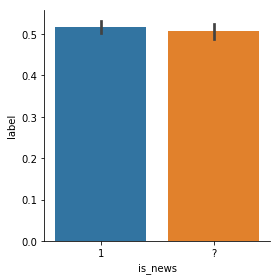

In [130]:
 import seaborn as sb
 %matplotlib inline

 sb.factorplot(x='is_news', 
               y='label',
               kind='bar',
               data = data)

### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

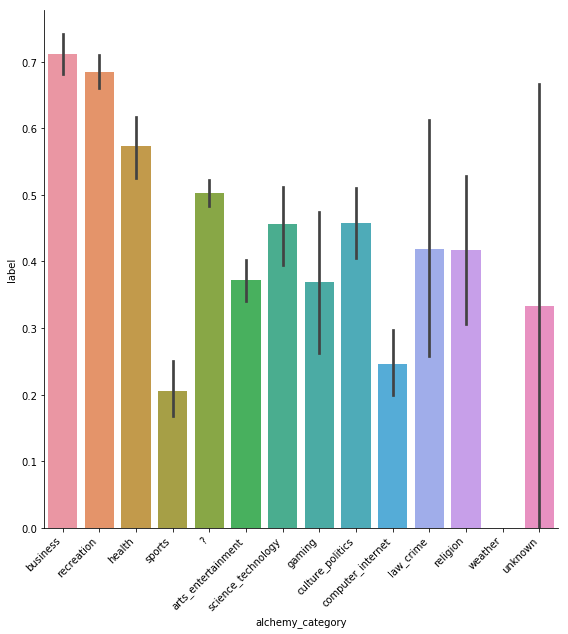

In [131]:
data.groupby(['alchemy_category'])[['label']].mean()


##  OR

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

In [132]:
data[data.alchemy_category == 'law_crime'].label.std()

0.501610310127101

In [133]:
data[data.alchemy_category == 'law_crime'].label.mean()

0.41935483870967744

### Exercise: 5. How many articles are there per category?

                    label
alchemy_category         
?                    2342
arts_entertainment    941
business              880
computer_internet     296
culture_politics      343
gaming                 76
health                506
law_crime              31
recreation           1229
religion               72
science_technology    289
sports                380
unknown                 6
weather                 4
                    label
alchemy_category         
?                    1176
arts_entertainment    350
business              626
computer_internet      73
culture_politics      157
gaming                 28
health                290
law_crime              13
recreation            841
religion               30
science_technology    132
sports                 78
unknown                 2
weather                 0


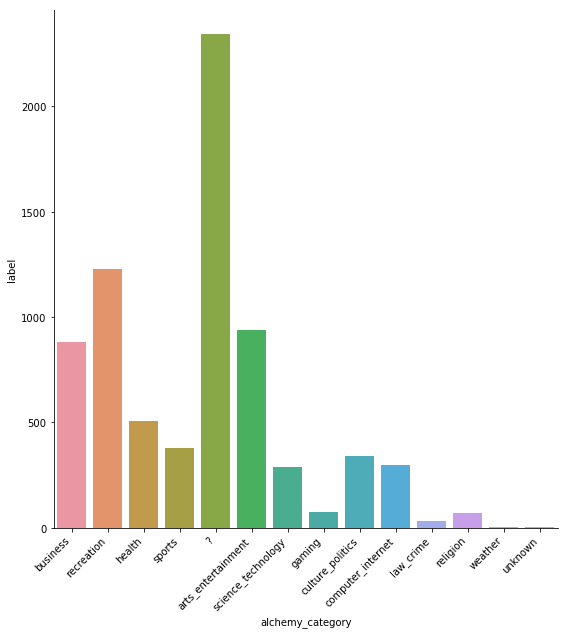

In [134]:
print(data.groupby(['alchemy_category'])[['label']].count())
print(data.groupby(['alchemy_category'])[['label']].sum())


##  OR

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8,
              estimator=len
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [135]:
# Option 1: Create a function to check for this
from collections import Counter

def has_recipe(text_in):
    try:
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except: 
        return 0
        
data['recipe'] = data['title'].map(has_recipe)

# Option 2: lambda functions

#data['recipe'] = data['title'].map(lambda t: 1 if 'recipe' in str(t).lower() else 0)


# Option 3: string functions
data['recipe'] = data['title'].str.contains('recipe')

In [136]:
print(Counter(data['recipe']))

Counter({False: 7030, True: 353, None: 12})


###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

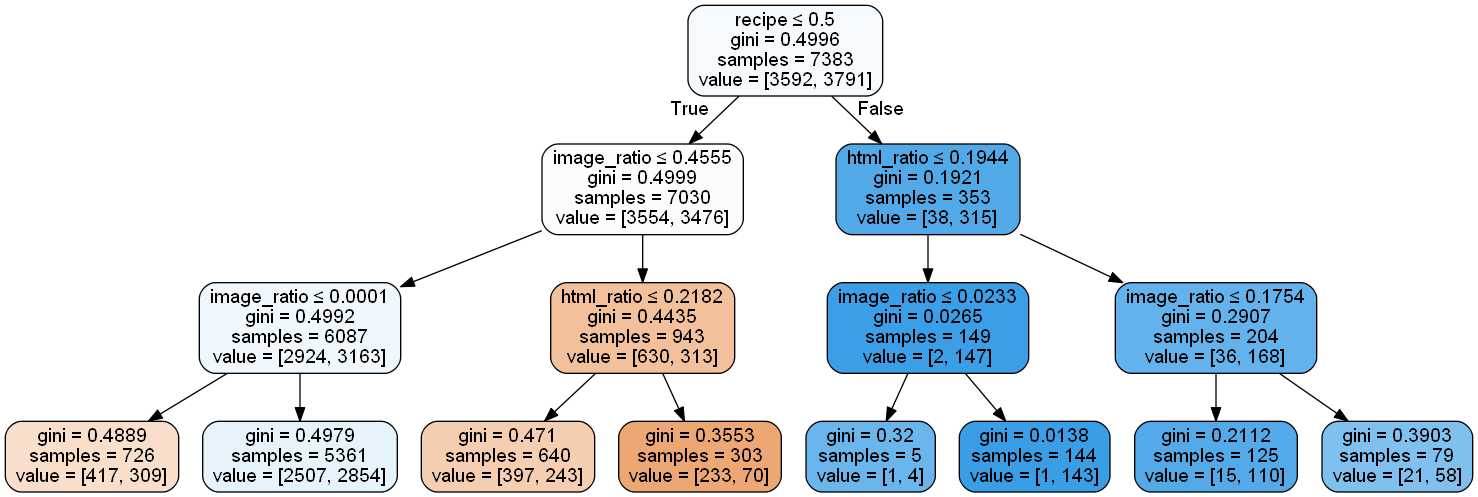

In [137]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus

dot_data = StringIO()
def build_tree_image(model,dot_data):
    export_graphviz(model, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = X.columns)  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph

graph = build_tree_image(model,dot_data)
Image(graph.create_png())


#from sklearn.tree import export_graphviz
#from os import system 
#def build_tree_image(model):
#    dotfile = open("tree.dot", 'w')
#    export_graphviz(model,
#                              out_file = dotfile,
#                              feature_names = X.columns)
#    dotfile.close()
#    system("dot -Tpng tree.dot -o tree.png")
    
#build_tree_image(model)
#labels = model.predict(X)
#labels

#labels = model.predict(X)
#labels

In [138]:
labels = model.predict_proba(X)
labels

array([[ 0.46763663,  0.53236337],
       [ 0.46763663,  0.53236337],
       [ 0.46763663,  0.53236337],
       ..., 
       [ 0.7689769 ,  0.2310231 ],
       [ 0.57438017,  0.42561983],
       [ 0.6203125 ,  0.3796875 ]])

In [139]:
model.n_features_    

3

In [140]:
model.predict_proba(X[(X['image_ratio']>0.4555) & (X['recipe']==0)])

array([[ 0.6203125,  0.3796875],
       [ 0.7689769,  0.2310231],
       [ 0.6203125,  0.3796875],
       ..., 
       [ 0.6203125,  0.3796875],
       [ 0.7689769,  0.2310231],
       [ 0.6203125,  0.3796875]])

In [141]:
model.predict(X[(X['image_ratio']>0.4555) & (X['recipe']==0)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.
 
1. In your groups from earlier, work on evaluating the decision tree using cross-validation methods.
2. What metrics would work best?  Why?

**Check:** Are you able to evaluate the decision tree model using cross-validation methods?

In [142]:
from sklearn.cross_validation import cross_val_score

# ... #

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.58417488  0.58045567  0.60179258  0.58135322  0.58409004], Average AUC 0.5863732768041588


In [143]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

for scoring in ['roc_auc','accuracy','recall','precision']:
    scores = cross_val_score(model, X, y, scoring=scoring, cv=5)
    print(scoring, ':')
    print('CV {} {}, Average {} {}'.format(scoring,scores,scoring,scores.mean()))

roc_auc :
CV roc_auc [ 0.53039557  0.53349254  0.54393985  0.52906233  0.55273738], Average roc_auc 0.5379255328131844
accuracy :
CV accuracy [ 0.53924222  0.53554502  0.54403794  0.52710027  0.55555556], Average accuracy 0.5402962019699015
recall :
CV recall [ 0.54940711  0.52638522  0.55145119  0.53034301  0.55804749], Average recall 0.5431268055106532
precision :
CV precision [ 0.54679144  0.5499316   0.55741935  0.54160982  0.57335128], Average precision 0.5538207000966199


In [148]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()
data['is_news'] = data[['is_news']].replace('?','0')
X = data[['image_ratio', 'html_ratio', 'recipe', 'is_news', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
print(X.head())
model.fit(X, y)

for scoring in ['roc_auc','accuracy','recall','precision']:
    scores = cross_val_score(model, X, y, scoring=scoring, cv=5)
    print(scoring, ':')
    print('CV {} {}, Average {} {}'.format(scoring,scores,scoring,scores.mean()))

   image_ratio  html_ratio recipe is_news
0     0.003883    0.245831  False       1
1     0.088652    0.203490  False       1
2     0.120536    0.226402  False       1
3     0.035343    0.265656  False       1
4     0.050473    0.228887  False       1
roc_auc :
CV roc_auc [ 0.52574667  0.53941453  0.54331697  0.53430263  0.54844886], Average roc_auc 0.5382459323198343
accuracy :
CV accuracy [ 0.52976996  0.54976303  0.53319783  0.53455285  0.55352304], Average accuracy 0.5401613410634167
recall :
CV recall [ 0.55072464  0.55013193  0.57124011  0.54881266  0.56992084], Average recall 0.5581660357156515
precision :
CV precision [ 0.54319372  0.55540541  0.56363636  0.53866667  0.55854643], Average precision 0.5518897172728239


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

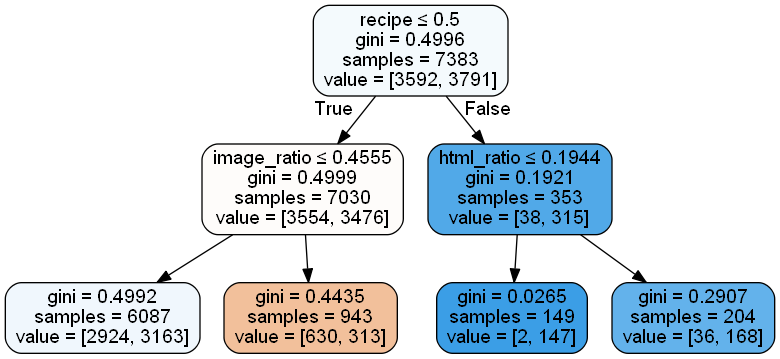

In [62]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
#build_tree_image(model)

dot_data = StringIO()
graph = build_tree_image(model,dot_data)
Image(graph.create_png())

In [66]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
params = {'max_depth': range(1,11),
          'min_samples_leaf': range(1,11)}
gs = GridSearchCV(model,param_grid=params,scoring='roc_auc',cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 11), 'min_samples_leaf': range(1, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [67]:
print(gs.best_score_)
print(gs.best_params_)

0.611494281835
{'max_depth': 6, 'min_samples_leaf': 1}


 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20, oob_score= True)
    
model.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [9]:
model.oob_score_ 

0.54015982662874173

### Demo: Extracting importance of features

In [10]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.529684
0,image_ratio,0.441386
2,recipe,0.028930


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [25]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [ 0.57115895  0.5895947   0.58113481], Average AUC 0.5806294863082421
n trees: 1, CV AUC [ 0.51562764  0.55326013  0.54063107], Average AUC 0.5365062802164134
n trees: 11, CV AUC [ 0.57077163  0.57663839  0.57738269], Average AUC 0.5749309040305025
n trees: 21, CV AUC [ 0.55882365  0.58705043  0.58540949], Average AUC 0.577094521215555
n trees: 31, CV AUC [ 0.56225698  0.58677449  0.58116325], Average AUC 0.5767315748040804
n trees: 41, CV AUC [ 0.56959747  0.59281676  0.57875852], Average AUC 0.5803909172432019
n trees: 51, CV AUC [ 0.56778043  0.58561356  0.57914051], Average AUC 0.5775114995510351
n trees: 61, CV AUC [ 0.57173843  0.58668097  0.57911902], Average AUC 0.5791794729625175
n trees: 71, CV AUC [ 0.56884595  0.58963039  0.58280896], Average AUC 0.5804284359462112
n trees: 81, CV AUC [ 0.56732542  0.59058049  0.58253776], Average AUC 0.5801478904653642
n trees: 91, CV AUC [ 0.5671557   0.58990964  0.57909024], Average AUC 0.5787185276423664


In [26]:
from sklearn import grid_search, cross_validation

gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={'n_estimators': [i for i in range(1, 100, 10)]},
    cv=cross_validation.KFold(n=len(X), n_folds=10),
    scoring='roc_auc'
)
gs.fit(X,y)

C:\Users\Ayham\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=sklearn.cross_validation.KFold(n=7383, n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [18]:
print(gs.grid_scores_)
print(gs.best_estimator_)

[mean: 0.53650, std: 0.01923, params: {'n_estimators': 1}, mean: 0.56590, std: 0.01557, params: {'n_estimators': 11}, mean: 0.57378, std: 0.01846, params: {'n_estimators': 21}, mean: 0.57264, std: 0.01712, params: {'n_estimators': 31}, mean: 0.57529, std: 0.01615, params: {'n_estimators': 41}, mean: 0.57818, std: 0.01446, params: {'n_estimators': 51}, mean: 0.57631, std: 0.01460, params: {'n_estimators': 61}, mean: 0.57552, std: 0.01350, params: {'n_estimators': 71}, mean: 0.57597, std: 0.01563, params: {'n_estimators': 81}, mean: 0.57798, std: 0.01557, params: {'n_estimators': 91}]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [27]:
## 1. Building a model with more relevant features

model = RandomForestClassifier(n_estimators=50)

# Continue to add features to X
#     Build dummy features, include quantitative features, or add text features
X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()

y = X['label']

X.drop('label', axis=1, inplace=True)


## 2a. Evaluate predictive performance for the given feature set
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# 3 (BONUS): Adding in text features

# Check for keywords in the title
data['PhotoInTitle'] = data['title'].fillna('').str.lower().str.contains('photo').astype(int)
X = data[['image_ratio', 'html_ratio', 'recipe', 'PhotoInTitle', 'label']].dropna()
X.drop('label', axis=1, inplace=True)


scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


## 2b. Evaluating feature importances

# Fit a model on the whole dataset
model.fit(X, y)

# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

CV AUC [ 0.57010861  0.58765453  0.58110935], Average AUC 0.5796241594244022
CV AUC [ 0.56345326  0.59043508  0.59001886], Average AUC 0.5813024006148378


,Features,Importance Score
1,html_ratio,0.526946
0,image_ratio,0.437745
2,recipe,0.029822
3,PhotoInTitle,0.005487
